## Importing Libraries

In [53]:
!pip install np_utils

In [54]:
import pandas as pd
import numpy as np
import random
import warnings
import time
import datetime
import re
import string
import itertools
import pickle
import joblib
import nltk
import csv

In [55]:
# import nltk
# from nltk.corpus import stopwords
from nltk.corpus import stopwords, wordnet
# stop = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict

import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model
# from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

##Data

In [56]:
# from google.colab import files
# data=files.upload()

In [57]:
df= pd.read_csv('Hinglish_Finanacial_Chats.csv')
display(df.sample(10))
print(df.shape)

,Text,Sentiment
169,"Haan yaar, wahi ultimate goal hai na hum sab k...",Negative
482,"Haan yaar, margin trading ka kya concept hai? ...",Positive
932,FGH Industries' expansion plans receive regula...,Positive
404,"Sahi kaha bhai, unki trading philosophies aur ...",Negative
959,EFG Technologies' new product receives industr...,Positive
567,"""BXC Inc. is facing a potential hostile takeov...",Negative
380,"Sahi kaha bhai, humility and beginner's mindse...",Negative
251,Waah kya idea hai bhai! Having that daily disc...,Positive
359,"Sahi hai bhai, pehle se hi shuru kar dete hain...",Negative
860,"""BXC Inc. is facing a potential cybersecurity ...",Negative


(1116, 2)


Sentiment
Positive    621
Negative    451
Neutral      44
Name: count, dtype: int64


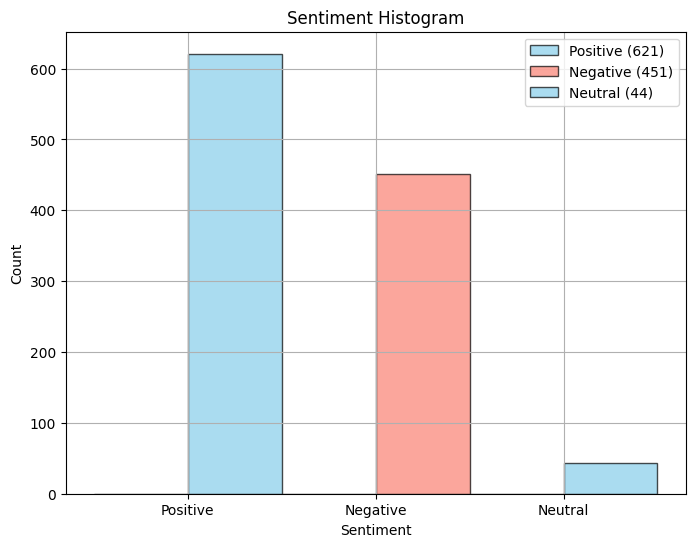

In [58]:
import matplotlib.pyplot as plt

# Count the frequency of each sentiment category
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

# Create a histogram plot for each sentiment category
plt.figure(figsize=(8, 6))
colors = ['skyblue', 'salmon'] * (len(sentiment_counts) // 2 + 1)  # Repeat the list to ensure enough colors
for sentiment, count in sentiment_counts.items():
    plt.hist([sentiment] * count, bins=2, edgecolor='black', color=colors.pop(0), alpha=0.7, label=f'{sentiment} ({count})')

plt.title('Sentiment Histogram')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()



In [59]:
def fun(i):
  # print(i)
  if i=='Positive':
    return 1
  else:
    return 0

In [60]:
df = df[['Sentiment', 'Text']]

df['Sentiment']= df['Sentiment'].apply(fun)


In [61]:
display(df.sample(5))

,Sentiment,Text
850,1,"""BCD Ltd. is rumored to be in talks for a majo..."
922,0,BCD Ltd faces allegations of accounting irregu...
799,0,"""FZG Corp's earnings call hinted at challenges..."
890,0,"""VWX Corp's quarterly revenue missed expectati..."
1067,1,DEY Industries ki earnings call ne strong inte...


In [62]:
df.shape

(1116, 2)

In [63]:
df['Sentiment'].value_counts()

Sentiment
1    621
0    495
Name: count, dtype: int64

##Data cleaning

In [64]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [66]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [68]:
df['clean_text'] = df['Text'].apply(lambda x: remove_url(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punct(str(x)))
df['clean_text'] = df['clean_text'].apply(word_tokenize)
df['clean_text'] = df['clean_text'].apply(lambda x: [word.lower() for word in x])
# df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df['clean_text'] = df['clean_text'].apply(nltk.tag.pos_tag)

In [69]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [70]:
df['clean_text'] = df['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
# df['clean_text'] = df['clean_text'].apply(
    # lambda x: [word for word in x if word not in stop])
df['clean_text'] = [' '.join(map(str, l)) for l in df['clean_text']]

In [71]:
display(df.sample(5))

,Sentiment,Text,clean_text
272,0,"Absolutely bhai, long-term wealth creation hi ...",absolutely bhai longterm wealth creation hi to...
683,0,"""EFG Corp's CEO resignation sent shockwaves th...",efg corp ceo resignation send shockwaves throu...
296,1,"Makes sense, digital disruption is a major the...",make sense digital disruption be a major theme...
289,1,"So true man, humility and willingness to learn...",so true man humility and willingness to learn ...
24,1,"Haan chalo aaj Friday hai, thodi chill karte h...",haan chalo aaj friday hai thodi chill karte ha...


#**Triplet Loss**

###Data Preparation

In [72]:
data_review_initial = list(df[df['Sentiment'] == 1]['clean_text'])
non_data_review_initial = list(df[df['Sentiment'] == 0]['clean_text'])

# Taking 1000 samples from the entire data
data_review = data_review_initial[:1000]
non_data_review = non_data_review_initial[:1000]

# Creating pairs of data for siamese training => labels for identity loss and class for data_review or non data_review
df2 = pd.DataFrame(columns=['Anchor', 'Positive', 'Negative', 'label', 'class'])

for data in data_review:
  a = data
  p = random.choice(data_review)
  n = random.choice(non_data_review)

  df2.loc[len(df2)] = [a, p, n, 1, 1]


for data in non_data_review:
  a = data
  p = random.choice(non_data_review)
  n = random.choice(data_review)

  df2.loc[len(df2)] = [a, p, n, 1, 0]


In [73]:
df2.shape

(1116, 5)

In [74]:
display(df2.sample(5))

,Anchor,Positive,Negative,label,class
412,yza corps earnings call reveal strong cash flo...,xyza corps new product launch exceed sale fore...,fzg corps earnings call hint at challenge ahea...,1,1
734,achha aur it mein largecap ke alawa kuch midca...,jkl ltd be face a potential sec investigation ...,nahi yaar itni jaldi nahi hoga recession aur p...,1,0
759,technical analysis bhi kafi kaam aayega aise o...,bxc inc be face a potential cybersecurity brea...,efg corp ke ceo ne company ke stock ka bada hi...,1,0
137,sahi kaha thats why prudent risk management st...,on point bhai sapne dekhne se kuch nahi hota u...,efg corp ceo resignation send shockwaves throu...,1,1
1019,bxc inc be face a potential cybersecurity brea...,bilkul bhai kisi bhi strategy ko follow karne ...,for sure man supplydemand dynamic market profi...,1,0


##Data split

In [75]:
X, X_test, y, y_test = train_test_split(df2[['Anchor', 'Positive', 'Negative']], df2[['label', 'class']], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X[['Anchor', 'Positive', 'Negative']], y[['label', 'class']], test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(713, 3) (179, 3) (224, 3) (713, 2) (179, 2) (224, 2)


In [76]:
X_train['text'] = X_train[['Anchor', 'Positive', 'Negative']].apply(lambda x: str(x[0])+" "+str(x[1])+" "+str(x[2]), axis=1)

##Glove Embeddings

In [77]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['Anchor'] = X_train['Anchor'].astype(str)
X_train['Positive'] = X_train['Positive'].astype(str)
X_train['Negative'] = X_train['Negative'].astype(str)
X_val['Anchor'] = X_val['Anchor'].astype(str)
X_val['Positive'] = X_val['Positive'].astype(str)
X_val['Negative'] = X_val['Negative'].astype(str)
X_test['Anchor'] = X_test['Anchor'].astype(str)
X_test['Positive'] = X_test['Positive'].astype(str)
X_test['Negative'] = X_test['Negative'].astype(str)

In [78]:
train_q1_seq = t.texts_to_sequences(X_train['Anchor'].values)
train_q2_seq = t.texts_to_sequences(X_train['Positive'].values)
train_q3_seq = t.texts_to_sequences(X_train['Negative'].values)
val_q1_seq = t.texts_to_sequences(X_val['Anchor'].values)
val_q2_seq = t.texts_to_sequences(X_val['Positive'].values)
val_q3_seq = t.texts_to_sequences(X_val['Negative'].values)
test_q1_seq = t.texts_to_sequences(X_test['Anchor'].values)
test_q2_seq = t.texts_to_sequences(X_test['Positive'].values)
test_q3_seq = t.texts_to_sequences(X_test['Negative'].values)

In [79]:
max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
train_q3_seq = pad_sequences(train_q3_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')
val_q3_seq = pad_sequences(val_q3_seq, maxlen=max_len, padding='post')
test_q1_seq = pad_sequences(test_q1_seq, maxlen=max_len, padding='post')
test_q2_seq = pad_sequences(test_q2_seq, maxlen=max_len, padding='post')
test_q3_seq = pad_sequences(test_q3_seq, maxlen=max_len, padding='post')

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# GLOVE_EMB = '/content/glove.6B.300d.txt'

In [82]:
embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 32771 word vectors.


In [83]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 32771 word vectors.


In [84]:
print(embedding_matrix.shape)

(2169, 300)


##Siamese Model

In [85]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [86]:
def embedding_model():

  network = Sequential()
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1,
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix],
                       input_length=train_q1_seq.shape[1],trainable=False))
  network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))

  network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  return network


In [87]:
def build_network(base_model):

  input_1 = Input(shape=(train_q1_seq.shape[1],))
  input_2 = Input(shape=(train_q2_seq.shape[1],))
  input_3 = Input(shape=(train_q3_seq.shape[1],))

  A = base_model(input_1)
  P = base_model(input_2)
  N = base_model(input_3)

  loss = Lambda(triplet_loss)([A, P, N])
  model = Model(inputs = [input_1, input_2, input_3], outputs = loss)
  model.compile(loss = identity_loss, optimizer = Adam(0.001))
  return model

In [88]:
base_model = embedding_model()
model = build_network(base_model)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 2)                    2382926   ['input_5[0][0]',             
                                                                     'input_6[0][0]',       

In [89]:
y_train_label = np.asarray(y_train['label']).astype('float32')
y_val_label = np.asarray(y_val['label']).astype('float32')
y_test_label = np.asarray(y_test['label']).astype('float32')

y_train_class = np.asarray(y_train['class']).astype('float32')
y_val_class = np.asarray(y_val['class']).astype('float32')
y_test_class = np.asarray(y_test['class']).astype('float32')

In [90]:
history = model.fit([train_q1_seq,train_q2_seq, train_q3_seq],y_train_label.reshape(-1,1), epochs = 10,
          batch_size=32,validation_data=([val_q1_seq, val_q2_seq, val_q3_seq],y_val_label.reshape(-1,1)))

Epoch 1/10
23/23 [==============================] - 41s 1s/step - loss: 0.2930 - val_loss: 0.2383
Epoch 2/10
23/23 [==============================] - 16s 707ms/step - loss: 0.1774 - val_loss: 0.1992
Epoch 3/10
23/23 [==============================] - 16s 699ms/step - loss: 0.1258 - val_loss: 0.1851
Epoch 4/10
23/23 [==============================] - 16s 709ms/step - loss: 0.0845 - val_loss: 0.1931
Epoch 5/10
23/23 [==============================] - 16s 695ms/step - loss: 0.0551 - val_loss: 0.1965
Epoch 6/10
23/23 [==============================] - 18s 790ms/step - loss: 0.0401 - val_loss: 0.2370
Epoch 7/10
23/23 [==============================] - 16s 711ms/step - loss: 0.0300 - val_loss: 0.2619
Epoch 8/10
23/23 [==============================] - 17s 739ms/step - loss: 0.0349 - val_loss: 0.2088
Epoch 9/10
23/23 [==============================] - 16s 691ms/step - loss: 0.0301 - val_loss: 0.2604
Epoch 10/10
23/23 [==============================] - 16s 719ms/step - loss: 0.0220 - val_loss:

## Evaluation

In [91]:
X_train_eval = base_model.predict(train_q1_seq)
X_test_eval = base_model.predict(test_q1_seq)

# TSNE - dimensionality reduction for data visualization
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_eval)

7/7 [==============================] - 0s 32ms/step


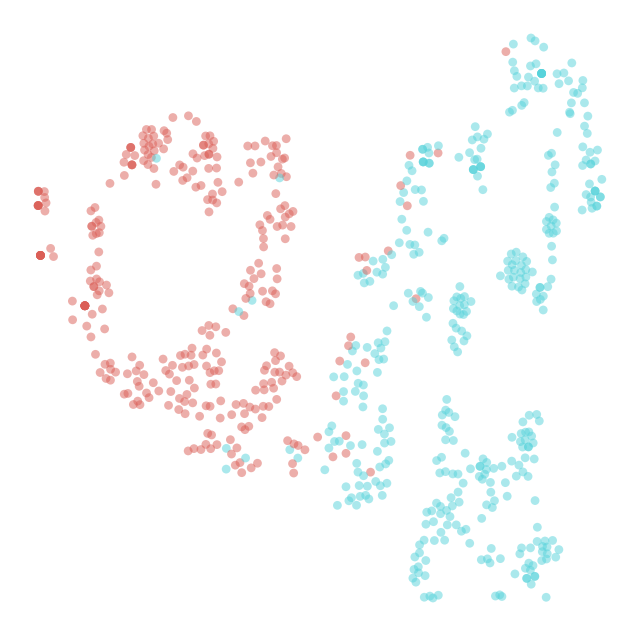

In [92]:
def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int_)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

scatter(train_tsne_embeds, y_train_class)

In [93]:
from keras.utils import to_categorical

In [94]:
classifier_input = Input(shape=(2,))
classifier_output = Dense(2, activation='softmax')(classifier_input)
classifier_model = Model(classifier_input, classifier_output)

# onehot encoding vectors to 2 classes
Y_train_onehot = to_categorical(y_train_class, 2)
Y_test_onehot = to_categorical(y_test_class, 2)

classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier_model.fit(X_train_eval,Y_train_onehot, validation_data=(X_test_eval, Y_test_onehot),epochs=5)

Epoch 1/5
23/23 [==============================] - 1s 10ms/step - loss: 0.4349 - accuracy: 0.9481 - val_loss: 0.4906 - val_accuracy: 0.8571
Epoch 2/5
23/23 [==============================] - 0s 4ms/step - loss: 0.4252 - accuracy: 0.9481 - val_loss: 0.4834 - val_accuracy: 0.8571
Epoch 3/5
23/23 [==============================] - 0s 4ms/step - loss: 0.4162 - accuracy: 0.9523 - val_loss: 0.4766 - val_accuracy: 0.8571
Epoch 4/5
23/23 [==============================] - 0s 4ms/step - loss: 0.4078 - accuracy: 0.9593 - val_loss: 0.4704 - val_accuracy: 0.8616
Epoch 5/5
23/23 [==============================] - 0s 4ms/step - loss: 0.3997 - accuracy: 0.9635 - val_loss: 0.4644 - val_accuracy: 0.8661


In [95]:
X_train_eval.shape

(713, 2)

#Visualization

In [96]:
X_train_eval = base_model.predict(train_q1_seq)
X_test_eval = base_model.predict(test_q1_seq)

7/7 [==============================] - 0s 51ms/step


In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [98]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already trained your classifier model and have predictions and true labels

# Predict labels for both train and test data
y_train_pred = classifier_model.predict(X_train_eval)
y_test_pred = classifier_model.predict(X_test_eval)

# Convert predicted continuous values to binary labels (0 or 1) based on a threshold
threshold = 0.5  # You can set this threshold value according to your preference
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_test_pred_binary = (y_test_pred > threshold).astype(int)

# Convert true labels (Y_train_onehot, Y_test_onehot) to a 1D array if necessary
y_train_true = Y_train_onehot.argmax(axis=1)
y_test_true = Y_test_onehot.argmax(axis=1)
y_test_pred_binary = y_test_pred_binary.argmax(axis=1)
y_train_pred_binary = y_train_pred_binary.argmax(axis=1)

# Calculate confusion matrix
train_cnf_matrix = confusion_matrix(y_train_true, y_train_pred_binary)
test_cnf_matrix = confusion_matrix(y_test_true, y_test_pred_binary)



7/7 [==============================] - 0s 3ms/step


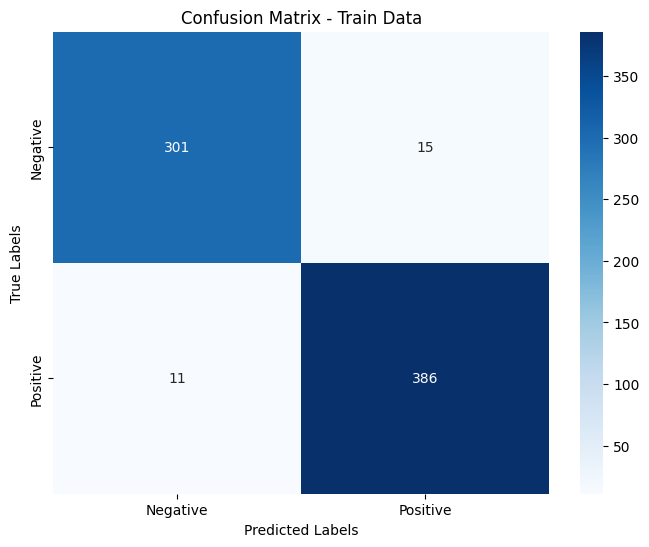

In [99]:
# Plot confusion matrix for train data
plt.figure(figsize=(8, 6))
sns.heatmap(train_cnf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Train Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

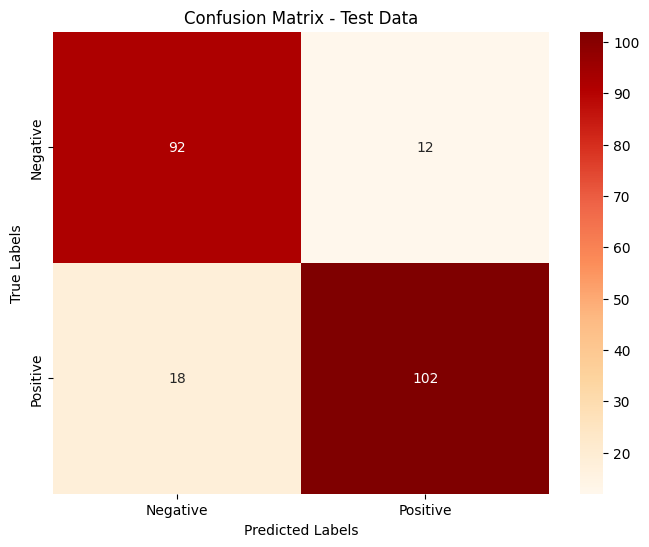

In [100]:
# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_cnf_matrix, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [103]:
train_acc = (train_cnf_matrix[0][0] + train_cnf_matrix[1][1]) / ( train_cnf_matrix[0][0] + train_cnf_matrix[0][1] +
             train_cnf_matrix[1][0] + train_cnf_matrix[1][1])

test_acc = (test_cnf_matrix[0][0] + test_cnf_matrix[1][1]) / ( test_cnf_matrix[0][0] + test_cnf_matrix[0][1] +
            test_cnf_matrix[1][0] + test_cnf_matrix[1][1] )


train_prec = (train_cnf_matrix[1][1]) / (train_cnf_matrix[1][1] + train_cnf_matrix[1][0])



test_prec = (test_cnf_matrix[1][1]) / (test_cnf_matrix[1][1] + test_cnf_matrix[1][0])


train_recall = (train_cnf_matrix[1][1]) / (train_cnf_matrix[1][1] + train_cnf_matrix[0][1])


test_recall = (test_cnf_matrix[1][1]) / (test_cnf_matrix[1][1] + test_cnf_matrix[0][1])


train_f1_score = (2 * train_prec * train_recall) / (train_prec + train_recall)

test_f1_score = (2 * test_prec * test_recall) / (test_prec + test_recall)



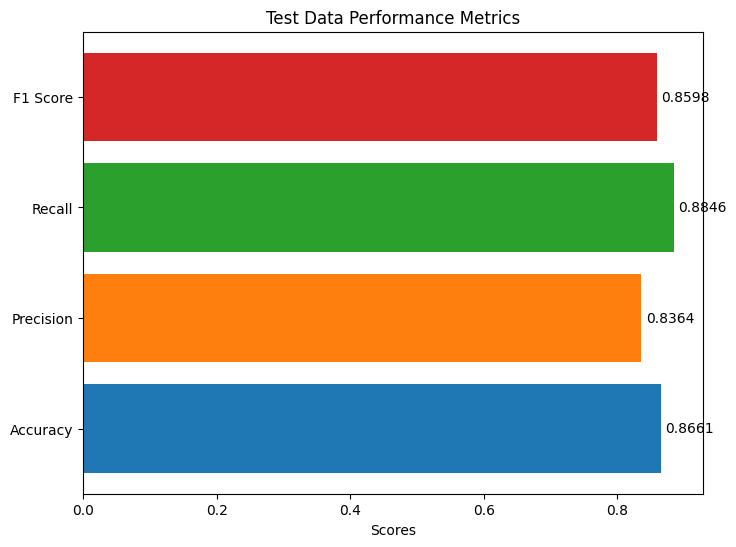

In [104]:
# @title
import matplotlib.pyplot as plt
import numpy as np

# Calculate and print accuracy, precision, recall, and F1-score for test data only
test_acc = (test_cnf_matrix[0][0] + test_cnf_matrix[1][1]) / test_cnf_matrix.sum()

test_prec = test_cnf_matrix[0][0] / (test_cnf_matrix[0][0] + test_cnf_matrix[1][0])

test_recall = test_cnf_matrix[0][0] / (test_cnf_matrix[0][0] + test_cnf_matrix[0][1])

# Calculate F1-score
test_f1_score = 2 * (test_prec * test_recall) / (test_prec + test_recall)

# Plot the metrics
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
test_scores = [test_acc, test_prec, test_recall, test_f1_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

rects = ax.barh(x, test_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Scores')
ax.set_title('Test Data Performance Metrics')
ax.set_yticks(x)
ax.set_yticklabels(labels)

# Add data labels
def add_labels(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{:.4f}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

add_labels(rects)

plt.show()


In [110]:
# @title
print("[1.1] Train accuracy")
print("    ",train_acc*100)

print("[1.2] Test Accuracy")
print("    " , test_acc*100)

print( " ")

print("[2.1] Train Precision")
print("    " , train_prec)

print("[2.2] Test Precision")
print("    " , test_prec)

print( " ")

print("[3.1] Train Recall")
print("    " , train_recall)

print("[3.2] Test Recall")
print("    " , test_recall)

print( " ")

print("[4.1] Train F1 Score")
print("    " , train_f1_score)

print("[4.2] Test F1 Score")
print("    " , test_f1_score)

[1.1] Train accuracy
     96.35343618513323
[1.2] Test Accuracy
     86.60714285714286
 
[2.1] Train Precision
     0.9722921914357683
[2.2] Test Precision
     0.8363636363636363
 
[3.1] Train Recall
     0.9625935162094763
[3.2] Test Recall
     0.8846153846153846
 
[4.1] Train F1 Score
     0.9674185463659148
[4.2] Test F1 Score
     0.8598130841121494
